## First we sort the reads

this script takes pacbio fasta files and keeps 5'->3' sequences and gives the reverse compliment of any sequences in the 3'->5' direction. 
     then it outputs the files into seqsfwd folder.

This script gets rid of sequences that don't have both ends. It also gets rid of sequences that have the end reference sequences
     in both the forward and reverse direction in the same read as this resulted in some pcr or sequencing error.

Sequences that have no forward or reverse of either the CAG (5') or pA (3') ends at all are put into mystery sequences file : seqfwd/mysterseqs

In [2]:
import os
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
import numpy as np
from statistics import mode
import random
from matplotlib import pyplot as plt

# Make the 5' and 3' list of sequences. 



#### The search at the 5' end and 3' end is broken into relativly short sequences as the error rate of sequencing is high so I am searching for a list of sequences representing sequences of the 5' and 3' ends for matches. 

In [5]:
'''
I made a 15 nt window to search (stringLength) and picked the 5shift to be larger than the 3shift because the 5' string is longer and would there for become more 
computationally expensive to shift by 3
'''

def MakeSearchLists(FivePrimeFwd, ThreePrimeFwd, stringLength = 15, FiveShift = 5, ThreeShift = 3):
    #check it is uppercase
    FivePrimeForward = FivePrimeFwd.upper()
    ThreePrimeForward = ThreePrimeFwd.upper()
    #making forward lists
    FiveFWDTable, FiveREVTable, ThreeFWDTable, ThreeREVTable = [], [], [], []
    x5 = 0 + stringLength
    while x5 < len(FivePrimeForward):
        FiveFWDTable.append(FivePrimeForward[(x5-stringLength):x5])
        x5 += FiveShift
    x3 = 0 + stringLength
    while x3 < len(ThreePrimeForward):
        ThreeFWDTable.append(ThreePrimeForward[(x3-stringLength):x3])
        x3 += ThreeShift
    #make reverse compliment Lists
    for sequence in FiveFWDTable:
        FiveREVTable.append(sequence.reverse_complement())
    for sequence in ThreeFWDTable:
        ThreeREVTable.append(sequence.reverse_complement())
    return(FiveFWDTable, FiveREVTable, ThreeFWDTable, ThreeREVTable)

### This is the selected sequence in Polb. I had to play with this a bit

## Do the Sorting of Sequences

In [6]:
def Sorting(inputFileName, FivePrimeFwd, ThreePrimeFwd, outputStats = 'dataSummary'):
    all_files = []
    my_list = [] #this is the list for the appended sequences that are either correct direction or get .reversecompliment and then appended
    mysterylist = [] #this is the list of things that didn't match
    countAll = 0 #this is to count reads in original file
    count5endF, count5endR, count3endF, count3endR = 0, 0, 0 ,0 #counting all different read types
    countF, countR = 0, 0
    mystery = 0 #this will count reads that have neither my 5' list nor 3' lists in them
    countFinal = 0#counts the sequence in the final outpful file
    bothDirections = 0 #counts reads that have either 5' end or 3' in both forward and reverse complement - which means fucked up somehow
    
    #making my search lists 
    FiveFWDTable, FiveREVTable, ThreeFWDTable, ThreeREVTable = MakeSearchLists(FivePrimeFwd, ThreePrimeFwd)
    
    for sequence in SeqIO.parse(inputFileName, "fastq"):
        all_files.append(sequence)
        countAll += 1
        if any(listSeq in sequence for listSeq in FiveFWDTable): 
            count5endF += 1
        if any(listSeq in sequence for listSeq in FiveREVTable): 
            count5endR += 1
        if any(listSeq in sequence for listSeq in ThreeFWDTable):
             count3endF += 1
        if any(listSeq in sequence for listSeq in ThreeREVTable):
            count3endR += 1
        ###################### making the list of correct sequences
        #first is to exclude sequences with sequence going in both directions as this means some weird error happenend
        if (any(listSeq in sequence for listSeq in FiveFWDTable) or any(listSeq in sequence for listSeq in ThreeFWDTable)) and (any(listSeq in sequence for listSeq in FiveREVTable) or any(listSeq in sequence for listSeq in ThreeREVTable)):
            bothDirections += 1  
        #forward sequences containign both ends
        elif (any(listSeq in sequence for listSeq in FiveFWDTable) and any(listSeq in sequence for listSeq in ThreeFWDTable)):
            countF += 1
            my_list.append(sequence)           
        #reverse sequences and reverse them while keeping the id name and any othe rinfromation
        elif (any(listSeq in sequence for listSeq in FiveREVTable) and any(listSeq in sequence for listSeq in ThreeREVTable)):
            my_list.append(sequence.reverse_complement(id=True, name=True, description=True, annotations=True))
            countR += 1
        #if this does not have a sequence from the 5 or 3 end mystery  file
        elif (any(listSeq not in sequence for listSeq in FiveFWDTable) and any(listSeq not in sequence for listSeq in FiveREVTable)) and (any(listSeq not in sequence for listSeq in ThreeFWDTable) and any(listSeq not in sequence for listSeq in ThreeREVTable)):
            mystery += 1
            mysterylist.append(sequence)
        
    ## Printing Stuff
    print("\nall seq in original file:", countAll)
    print("\n5'Fwd containg sequences:", count5endF, "\n3'endF containing seqs:", count3endF, "\n5'endR containing sequences:", count5endR, "\n3'endR containing seqs: ", count3endR)
    print("\n# total forward reads: ", countF)
    print("# of total reverse reads: ", countR)
    print("\nfinal count in new file going one direction: ", countF+countR)
    print("reads containing both F and R seq: ", bothDirections, "\n\nMistery sequence without any recognized sequence: ", mystery)
    
    outputData =  np.array([('Num seq in original file:',countAll), ("5'Fwd containg sequences:", count5endF), ("3'endF containing seqs:", count3endF), ("3'endR containing seqs: ", count3endR), ("# total forward reads ", countF), ("# of total reverse reads:", countR),("final count in new file going one direction: ", countF + countR),("reads containing both F and R seq:", bothDirections), ("Mistery sequence without any recognized sequence:", mystery)])
    np.savetxt(outputStats +'.csv', outputData, delimiter=',', fmt=['%s','%s' ])
    
    return(my_list, mysterylist)

# Making Sequences Forward Facing

#### Define the unique ends for turning into a search list

In [7]:
FivePrimeFwd = Seq('ACTGGGGTTCAATTTTCTGTGTCCTTTATTTCAAACCTTATCACATGGTATTCATTTGTTTTTCATTTTCTGCTTTTTACTTTATCTTTTAGTGATTTGGTAAGCATTATATTCATATGACTTTTATATTTCTAATTTTCCATGTAGCCTGGAGTAGGAACAAAAATTGCTGAAAAGATTGATGAGTTTTTAGCAACTGGAAAATTACGTAAACTGGAAAAGGTAAAATTTTAACTTGTTTACTTCATTAATTATAGTATCTGCCTTTATGGCCACTATGTAGCGTCATTGCAGGGTGACCAATGTCATTCACTGTAGTGAGACTCACAGGAAATGAGGTGAGTGAAGTTGATGGCTTTAACTTTTTGAATGTTATTTCCATAAAATGTTCACTTGTTTTATGTGGCATTTAAGAGACTATTAACACCCGTAATAGAGTTGGCTCATCGTTTTCAGTACTATTCAGAAAAGAGATTATAAACTTTGACTGAAAGATCGTTATCTTTTAGAATTTCTTTATTTCTTTATTTATGTTTTTGAGATGGAGTCTTGCTCTGTCGCCCAGGCTGGAGTGCAGTGGCGCGATCTCGGCTCACTGCAAGCTCCGCCTCCTGGGTTCATGCCATTCTCCTGCCTCAGCCTCCTGAGTAGCTGGGACTACAGGCGCCCGCCACCACACCCAGCTAATTTTTTGCATTTTTAGTAGAGACGGGGTTTCACCATGTTAGCCAGTATGGTCTCGATCTCCTGACCTCGTGATCTGCCCGCCTCGGCCTCCCAAAGTGCTGGGATTACAGGCATGAGCCACCATACCCGGCCATCTTTTAGAATTTCTATGTTTACACTCTCCCAAGCATTTTTATGGTTTTATTTCACCCCATGATAGTAATTATATCACTTCTGATCTGTTAAGAATAGACCTTTTAAAAGTATTGGATAACTTAGAGATGAGACATCTTCAGTTACTCTGTTATTCACCTATTACTCCTTAGGTTACTTGTGAA', IUPAC.unambiguous_dna)
ThreePrimeFwd = Seq('cctataaGAGCATCTTCAGTCATTTCTGACATTCTGATTTATTTATATGAATaaaatgaaCAGTTTTCAAGTGCCATCTGTACATGGGCACTATGACAGC', IUPAC.unambiguous_dna)


#### Do the calculation for Targeted Polb
The data is saved in the PolbTargetedPreProcessingCleanupStats.csv file

In [8]:
inputFilePolbTargeted = "../RawData/Polb_Targeted.fastq"
outputFilePolbTargeted = os.path.abspath("../seqsfwd/Polb_Targeted.fasta")
### For the unknown sequences
mysterylistPolbTargeted = os.path.abspath("../seqsfwd/mysteryseqs/Polb_Targeted.fasta")

#run script
my_SortedList, MyMysterylist = Sorting(inputFilePolbTargeted, FivePrimeFwd, ThreePrimeFwd, 'PolbTargetedPreProcessingCleanupStats')




all seq in original file: 16786

5'Fwd containg sequences: 8289 
3'endF containing seqs: 9800 
5'endR containing sequences: 6997 
3'endR containing seqs:  8567

# total forward reads:  7121
# of total reverse reads:  5922

final count in new file going one direction:  13043
reads containing both F and R seq:  3026 

Mistery sequence without any recognized sequence:  717


In [91]:
SeqIO.write(MyMysterylist, mysterylistFilename, "fasta")
SeqIO.write(my_SortedList, outputFilePolbTargeted, "fasta")

13043

Text(0.5,1,'All Reads')

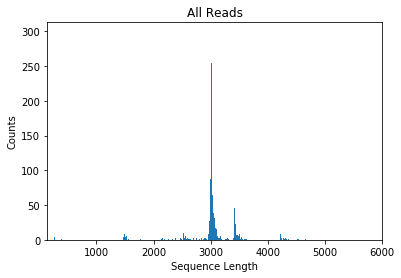

In [3]:
inputFileName = "../seqsfwd/Polb_Targeted.fasta"
Lengths1 = []

for sequence in SeqIO.parse(inputFileName, "fasta"):
    Lengths1.append(len(sequence))

fig1 = plt.figure()
bins = np.arange(200, 6000, 1)
plt.xlim([min(Lengths1), 6000])
plt.hist(Lengths1, bins=bins, alpha=1);

plt.xlabel('Sequence Length')
plt.ylabel('Counts')
plt.title('All Reads For targeted Polb Cells')

Text(0.5,1,'All Reads For Control Polb Cells')

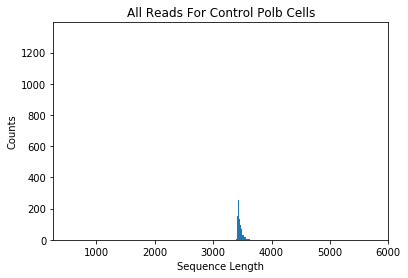

In [4]:
inputFileName = "../seqsfwd/Polb_Cntl.fasta"
Lengths1 = []

for sequence in SeqIO.parse(inputFileName, "fasta"):
    Lengths1.append(len(sequence))

fig1 = plt.figure()
bins = np.arange(200, 6000, 1)
plt.xlim([min(Lengths1), 6000])
plt.hist(Lengths1, bins=bins, alpha=1);

plt.xlabel('Sequence Length')
plt.ylabel('Counts')
plt.title('All Reads For Control Polb Cells')

#### Make the sorted, forward facing Control Polb FASTA File
Stats are saved in the PolbControlPreProcessingCleanupStats.csv file

In [92]:
inputFilePolbCntl = "../RawData/Polb_Cntl.fastq"
outputFilePolbCntl = os.path.abspath("../seqsfwd/Polb_Cntl.fasta")
### For the unknown sequences
mysterylistPolbCntl = os.path.abspath("../seqsfwd/mysteryseqs/mysteryPolb_Cntl.fasta")

#run script
my_SortedPolbCntlList, MyPolbCntlMysterylist = Sorting(inputFilePolbCntl, FivePrimeFwd, ThreePrimeFwd, 'PolbControlPreProcessingCleanupStats')



all seq in original file: 21040

5'Fwd containg sequences: 11215 
5'endR containing sequences: 9283 
3'endF containing seqs: 11950 
3'endR containing seqs:  10034

# total forward reads:  10481
# of total reverse reads:  8580

final count in new file going one direction:  19061
reads containing both F and R seq:  1548 

Mistery sequence without any recognized sequence:  431


In [ ]:
SeqIO.write(MyPolbCntlMysterylist, mysterylistPolbCntl, "fasta")
SeqIO.write(my_SortedPolbCntlList, outputFilePolbCntl, "fasta")

# Sort the Sequences Into Bins: Wildtype, Deletion, Replacement w/ Cherry

If it is replacement with Cherr

In [7]:
def MakeSortingLists(WildTypeSeq, ReplacementSeq, WildTypeUnique, stringLength = 15, ShiftWindow = 5):
         #Make sure all is in uppercase
    PolbWTEntire = WildTypeSeq.upper()
    PolbReplaceFWD = ReplacementSeq.upper()
    PolbWTShort = WildTypeUnique.upper()
        #Make the Empty Lists
    PolbWTentireFWDTable, PolbWTentireREVTable = [], []
    PolbReplaceFWDTable, PolbReplaceREVTable = [], [] 
    PolbWTShortFWDTable, PolbWTShortREVTable = [], []
        ##### Making Fwd Lists
    xWT = 0 + stringLength
    while xWT < len(PolbWTEntire):
        PolbWTentireFWDTable.append(PolbWTEntire[(xWT-stringLength):xWT])
        xWT += ShiftWindow
    xRep = 0 + stringLength
    while xRep < len(PolbReplaceFWD):
        PolbReplaceFWDTable.append(PolbReplaceFWD[(xRep-stringLength):xRep])
        xRep += ShiftWindow
    #short Seq
    xWTshort = 0 + stringLength
    while xWTshort < len(PolbWTShort):
        PolbWTShortFWDTable.append(PolbWTShort[(xWTshort-stringLength):xWTshort])
        xWTshort += 3
        ##### Make Rev Compliment
    for sequence in PolbWTentireFWDTable:
        PolbWTentireREVTable.append(sequence.reverse_complement())
    for sequence in PolbReplaceFWDTable:
        PolbReplaceREVTable.append(sequence.reverse_complement())
    for sequence in PolbWTShortFWDTable:
        PolbWTShortREVTable.append(sequence.reverse_complement())
    
    return(PolbWTentireFWDTable, PolbWTentireREVTable, PolbReplaceFWDTable, PolbReplaceREVTable, PolbWTShortFWDTable, PolbWTShortREVTable)
        

In [4]:
def SortingFunction(inputFileName, outputStats, WTSeq, ReplacementSeq, ShortWTseq, stringLength, ShiftWindow):
    countingAll = 0 
    WTfwd, WTrev, mCherryF, mCherryR = 0, 0, 0, 0
    HITI, HITImCherryF, HITImCherryR, Deletion = 0, 0, 0, 0 
    mCherryfwdList, mCherryfwdListSmall, mCherryrevList, WTfwdList, deletionList, deletionListSmall, WTREVList, HITIList = [], [], [], [], [], [], [], []
    
    PolbWTentireFWDTable, PolbWTentireREVTable, PolbReplaceFWDTable, PolbReplaceREVTable, PolbWTuniqueFWDTable, PolbWTuniqueREVTable \
        = MakeSortingLists(WTSeq, ReplacementSeq, ShortWTseq, stringLength, ShiftWindow)
    
    for sequence in SeqIO.parse(inputFileName, "fasta"):
        countingAll += 1
        if any(listSeq in sequence for listSeq in PolbReplaceFWDTable): 
            pass
        elif any(listSeq in sequence for listSeq in PolbReplaceREVTable): 
            pass
        elif any(listSeq in sequence for listSeq in PolbWTentireFWDTable):
            WTfwd +=1
            WTfwdList.append(sequence)
        elif any(listSeq in sequence for listSeq in PolbWTentireREVTable):
            WTrev +=1
            WTREVList.append(sequence)
    #simliar logic as above for finding HIROS but first sort out WT containing (UNIQUE WT table) seqs to get rid of possible HITI. 
    for sequence in SeqIO.parse(inputFileName, "fasta"):
        if any(listSeq in sequence for listSeq in PolbWTuniqueFWDTable):
            pass
        elif any(listSeq in sequence for listSeq in PolbWTuniqueREVTable):
            pass
        elif any(listSeq in sequence for listSeq in PolbReplaceFWDTable) and len(sequence) > 2850:
            mCherryF += 1
            mCherryfwdList.append(sequence)
        elif any(listSeq in sequence for listSeq in PolbReplaceFWDTable) and len(sequence) < 2850:
            mCherryfwdListSmall.append(sequence)
            
        elif any(listSeq in sequence for listSeq in PolbReplaceREVTable):
            mCherryR += 1
            mCherryrevList.append(sequence)

    #counting all HITI 
    HITIList = []
    for sequence in SeqIO.parse(inputFileName, "fasta"):
        if (any(listSeq in sequence for listSeq in PolbWTuniqueFWDTable) or any(listSeq in sequence for listSeq in PolbWTuniqueREVTable)) and ( any(listSeq in sequence for listSeq in PolbReplaceFWDTable) or any(listSeq in sequence for listSeq in PolbReplaceREVTable)):
            HITI += 1
            HITIList.append(sequence)

    for sequence in HITIList:
        if any(listSeq in sequence for listSeq in PolbReplaceFWDTable):
            HITImCherryF += 1
        elif any(listSeq in sequence for listSeq in PolbReplaceREVTable):
            HITImCherryR += 1

     #check for Deletion       
    for sequence in SeqIO.parse(inputFileName, "fasta"):
        if not(any(listSeq in sequence for listSeq in PolbWTentireFWDTable) or any(listSeq in sequence for listSeq in PolbWTentireREVTable) or any(listSeq in sequence for listSeq in PolbReplaceFWDTable) or any(listSeq in sequence for listSeq in PolbReplaceREVTable)):
            if len(sequence) > 1900:
                deletionList.append(sequence)
                Deletion += 1
            elif len(sequence) <= 1900:
                deletionListSmall.append(sequence)
        else:
            pass
 


    #Printing Results
    total = WTfwd + WTrev + mCherryF + mCherryR+ HITImCherryF + HITImCherryR + Deletion

    print("WT Exon FWD alignments:", WTfwd)
    print("WT Exon inverted alignments:", WTrev)
    print("mCherryF seq:", mCherryF)
    print("mCherryR seq:", mCherryR)
    print("HITI mCherryF:", HITImCherryF)
    print("HITI mCherryR:", HITImCherryR)
    print("Deletion counts:", Deletion)
    print("total counted ", total, "of reads in file:", countingAll )
    
    
    
    outputData =  np.array([('Num seq in original file:',countingAll), ("WT Exon FWD alignments:", WTfwd), ("WT Exon inverted alignments:", WTrev), \
                            ("mCherryF seq:", mCherryF), ("mCherryR seq:", mCherryR), ("HITI mCherryF:", HITImCherryF), \
                            ("HITI mCherryR:", HITImCherryR),("Deletion counts:", Deletion), ("total Identified ", total), ("Reads reads in file:", countingAll)])
    np.savetxt(outputStats +'.csv', outputData, delimiter=',', fmt=['%s','%s'])

    return(mCherryfwdList, mCherryfwdListSmall, WTfwdList, WTREVList, deletionList, deletionListSmall, HITIList,) 

### Doing Sorting for the Polb Targeted
Stats are save din the SortStatsPolbTargeted.csv file

In [5]:
PolbEntireWT = Seq('TTCATGTCTTTTAGCAGACTGGTATGTTTCCAATAAGATCATTTAAGTCCTCAAAGCATTCCTAAATCATTGTTAGACTTTTTTTTTTCTTAAAGATTCGGCAGGATGATACGAGTTCATCCATCAATTTCCTGACTCGAGTTAGTGGCATTGGGTAAGAACTATTTTTTAAGCAGACACAATCGTCAGTTAGTTTATTTTTCCTGTTAGCCAAAGTAAATTACATGCTGTTTCTCAAAACCTGTACTTCACCACCTCTGTACCTTAGCCATACAGTTCACCCTTCCATAGCTTATGATCTGAGGCCGATTCTTCAGATAGTGTCTCTACTGTAAGGTCCCCATCCAAGGCAGATGTTACCTCCTTCA', IUPAC.unambiguous_dna) 
PolbReplace = Seq('GATTGAGGGCAGAGGAAGTCTGCTAACATGCGGTGACGTGGAGGAGAATCCCGGCCCTGCTAGCATGGTGAGCAAGGGCGAGGAGGATAACATGGCCATCATCAAGGAGTTCATGCGCTTCAAGGTGCACATGGAGGGCTCCGTGAACGGCCACGAGTTCGAGATCGAGGGCGAGGGCGAGGGCCGCCCCTACGAGGGCACCCAGACCGCCAAGCTGAAGGTGACCAAGGGTGGCCCCCTGCCCTTCGCCTGGGACATCCTGTCCCCTCAGTTCATGTACGGCTCCAAGGCCTACGTGAAGCACCCCGCCGACATCCCCGACTACTTGAAGCTGTCCTTCCCCGAGGGCTTCAAGTGGGAGCGCGTGATGAACTTCGAGGACGGCGGCGTGGTGACCGTGACCCAGGACTCCTCCCTGCAGGACGGCGAGTTCATCTACAAGGTGAAGCTGCGCGGCACCAACTTCCCCTCAGACGGCCCCGTAATGCAGAAGAAAACCATGGGCTGGGAGGCCTCCTCCGAGCGGATGTACCCCGAGGACGGCGCCCTGAAGGGCGAGATCAAGCAGAGGCTGAAGCTGAAGGACGGCGGCCACTACGACGCTGAGGTCAAGACCACCTACAAGGCCAAGAAGCCCGTGCAGCTGCCCGGCGCCTACAACGTCAACATCAAGTTGGACATCACCTCCCACAACGAGGACTACACCATCGTGGAACAGTACGAACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTACAAGTAAGAATTCCTAGAGCTCGCTGATCAGCCTCGACTGTGCCTTCTAGTTGCCAGCCATCTGTTGTTTGCCCCTCCCCCGTGCCTTCCTTGACCCTGGAAGGTGCCACTCCCACTGTCCTTTCCTAATAAAATGAGGAAATTGCATCGCATTGTCTGAGTAGGTGTCATTCTATTCTGGGGGGTGGGGTGGGGCAGGACAGCAAGGGGGAGGATTGGGAAGAGAATAGCAGGCATGCTGGGGggatccctgcaggagctcgtcgacccatgggggcccgccccaactggggtaacctttgggctccccgggcgcgactagtgaattcagatctgatatctc', IUPAC.unambiguous_dna) 
PolbShortWT = Seq('AGATTCGGCAGGATGATACGAGTTCATCCATCAATTTCCTGACTCGAGTTAGTGGCATTGGGTA', IUPAC.unambiguous_dna) 


In [8]:
inputFileName = "../seqsfwd/Polb_Targeted.fasta"

mCherryfwdList, mCherryfwdListSmall, WTfwdList, WTREVList, deletionList, deletionListSmall, HitiList \
    = SortingFunction(inputFileName, 'SortStatsPolbTargetedNew', PolbEntireWT, PolbReplace, PolbShortWT, 15, 5)

WT Exon FWD alignments: 937
WT Exon inverted alignments: 1076
mCherryF seq: 349
mCherryR seq: 44
HITI mCherryF: 38
HITI mCherryR: 4
Deletion counts: 9784
total counted  12232 of reads in file: 13031


For Saving the Cells for Alignment:

In [93]:
outputFilemCherryHIROS = "../sortedseqs/Targeted/PolbCherry.fasta"
outputFilemCherryHIROSsmall = "../sortedseqs/Targeted/PolbCherrySmall.fasta"
outputFileWTfwd = "../sortedseqs/Targeted/WTpolb.fasta"
outputFileWTrev = "../sortedseqs/Targeted/WTREVpolb.fasta"
outputFiledel = "../sortedseqs/Targeted/PolbDel.fasta"
outputFiledelsmall = "../sortedseqs/Targeted/PolbDelSmall.fasta"

SeqIO.write(mCherryfwdList, outputFilemCherryHIROS, "fasta")
SeqIO.write(mCherryfwdListSmall, outputFilemCherryHIROSsmall, "fasta")
SeqIO.write(WTfwdList, outputFileWTfwd, "fasta")
SeqIO.write(WTREVList, outputFileWTrev, "fasta")
SeqIO.write(deletionList, outputFiledel, "fasta")
SeqIO.write(deletionListSmall, outputFiledelsmall, "fasta")

711

### Doing Sorting for the Polb Control
Stats are saved in the SortStatsPolbCntl.csv file

In [103]:
inputFileFwdCntl = "../seqsfwd/Polb_Cntl.fasta"

mCherryfwdList, mCherryfwdListSmall, WTfwdList, WTREVList, deletionList, deletionListSmall, HitiList \
     = SortingFunction(inputFileFwdCntl, 'SortStatsPolbCntl', PolbEntireWT, PolbReplace, PolbShortWT, 15, 5)

WT Exon FWD alignments: 19034
WT Exon inverted alignments: 0
mCherryF seq: 0
mCherryR seq: 0
HITI mCherryF: 0
HITI mCherryR: 2
Deletion counts: 2
total counted  19038 of reads in file: 19046


In [104]:
outputFileCntlWTfwd = "../sortedseqs/Control/WTCntlpolb.fasta"
outputFileCntlHITI = "../sortedseqs/Control/HITIControlpolb.fasta"
outputFileCntldel = "../sortedseqs/Control/PolbControlDel.fasta"

SeqIO.write(WTfwdList, outputFileCntlWTfwd, "fasta")
SeqIO.write(HitiList, outputFileCntlHITI, "fasta")
SeqIO.write(deletionList, outputFileCntldel, "fasta")


2

## Plotting of the Sorting for Targeted Cells


The control Cells were 100% wt looking so nothing interesting to view

In [8]:
#THIS CODE MAKES PLOTS IN PDF (VECTOR FORMAT)
from matplotlib.pyplot import *
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

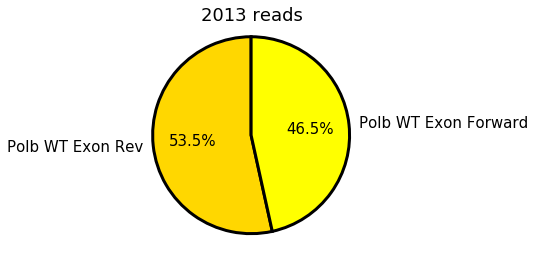

In [10]:
# Polb WT fwdrev
labels =  'Polb WT Exon Rev', 'Polb WT Exon Forward'
sizes = [1076,937 ]
colors = ['gold', 'yellow']
plt.rcParams['font.size'] = 15

# Plot
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=False, startangle=90,
        wedgeprops = {'linewidth':3, 'edgecolor': 'black'})
 
plt.axis('equal');
plt.title(str(1076+937) + ' reads')

#plt.savefig("./Plots/PolbWTRatio.png")
plt.savefig("./Plots/PolbWTRatio.pdf")

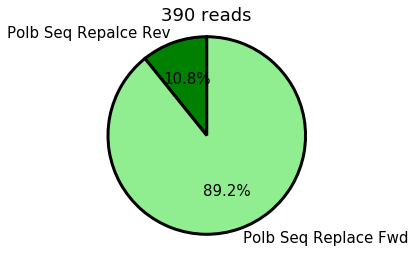

In [12]:
# Polb HIROS fwdrev
labels = 'Polb Seq Repalce Rev', 'Polb Seq Replace Fwd'
sizes = [42, 348]
colors = ['green', 'lightgreen']
plt.rcParams['font.size'] = 15

# Plot
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=False, startangle=90,
        wedgeprops = {'linewidth':3, 'edgecolor': 'black'})
plt.title(str(42+348) + ' reads')
 
plt.axis('equal');
#plt.savefig("./Plots/PolbReplaceRatio.png")
plt.savefig("./Plots/PolbReplaceRatio.pdf")

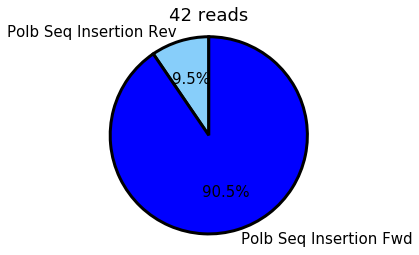

In [11]:
# Polb HITI fwdrev

labels = 'Polb Seq Insertion Rev','Polb Seq Insertion Fwd'
sizes = [4,38 ]
colors = ['lightskyblue','blue']
plt.rcParams['font.size'] = 15
explode = 0, 0.3
# Plot
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=False, startangle=90,
        wedgeprops = {'linewidth' :3, 'edgecolor': 'black'})
plt.title(str(4+38) + ' reads')


plt.axis('equal');
plt.savefig("./Plots/PolbInsertionRatio.png")
plt.savefig("./Plots/PolbInsertionRatio.pdf")

# Bash Scripts Using MiniMap2 to do alignment

For this part it is crucial to be running this .ipynb notebook from the correct conda enviornment

In [108]:
%%bash 
pwd
#we need to be in the same directory as the minimap script

/home/edanner/workspace/V2Seq/Scripts


In [109]:
%%bash
#the script for alignment -> sorted, indexed bam file
cat MiniMapscript.sh

#!/bin/sh

reference_file=$1
reads_file=$2
outputfile=$3



# run Minimap2 tool
#the pac bio setting didn't work well. Chopped reads into 500 bp for some reason.
#minimap2 -ax map-pb $reference_file $reads_file > $outputfile'.sam' 

#splice setting works
minimap2 -ax splice $reference_file $reads_file > $outputfile'.sam' 

echo $outputfile'.sam'
#this converts and indexes for IGV viewing or my analysis processing

# sam to bam
samtools view -Sb $outputfile'.sam' > $outputfile'.bam'

# sort bam file
samtools sort -o $outputfile.sorted.bam $outputfile.bam

# index
samtools index $outputfile.sorted.bam




In [3]:
%%bash
#Control WT:
bash MiniMapscript.sh ../refseqs/polbwt.fasta ../sortedseqs/Control/CntlWTpolb.fasta ../AlignmentMiniMap2/Polb/Cntl_PolbWT

../AlignmentMiniMap2/Polb/Cntl_PolbWT.sam


[M::mm_idx_gen::0.001*11.98] collected minimizers
[M::mm_idx_gen::0.002*8.39] sorted minimizers
[M::main::0.002*8.31] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.002*7.89] mid_occ = 3
[M::mm_idx_stat] kmer size: 15; skip: 5; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.002*7.54] distinct minimizers: 1154 (99.83% are singletons); average occurrences: 1.002; average spacing: 2.963
[M::worker_pipeline::17.319*2.94] mapped 18990 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 -ax splice ../refseqs/polbwt.fasta ../sortedseqs/Control/CntlWTpolb.fasta
[M::main] Real time: 17.321 sec; CPU: 50.841 sec; Peak RSS: 0.097 GB


In [ ]:
%%bash
#Targeted WT:
bash MiniMapscript.sh ../refseqs/polbwt.fasta ../sortedseqs/Targeted/WTpolb.fasta ../AlignmentMiniMap2/Polb/PolbTargetedWT


In [ ]:
%%bash
#Targeted WT-REV
bash MiniMapscript.sh ../refseqs/polbwt-rev.fasta ../sortedseqs/Targeted/WTREVpolb.fasta ../AlignmentMiniMap2/Polb/PolbTargetedWT_REV


In [ ]:
%%bash
#Targeted replacement:
bash MiniMapscript.sh ../refseqs/polbcherry.fasta ../sortedseqs/Targeted/PolbCherry.fasta ../AlignmentMiniMap2/Polb/TargetedPolbCherry


In [ ]:
%%bash
#Targeted Deletion:
bash MiniMapscript.sh ../refseqs/polbdel.fasta ../sortedseqs/Targeted/PolbDel.fasta ../AlignmentMiniMap2/Polb/PolbTargetedDel

- Can view the sorted, indexed, bam files in IGV
- Now the remaining Analysis and plotting is done in R 
